In [1]:
import nltk
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import tensorflow as tf
import random
import json
import pickle
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# stemmer = LancasterStemmer()
stemmer = SnowballStemmer('english')

# Reading the training data
with open('intents.json') as f:
    data = json.load(f)
    
try:
    with open('ys_dict.pickle', 'rb') as f:
        ys_ohe, ys_dict, xs_vec = pickle.load(f)
        
except:
    # Reading each sentence and corresponding class label
    xs = []
    ys = []
    for d in data['intents']:
        for dd in d['patterns']:

            xs.append(dd) # input data
            ys.append(d['tag']) # class labels

    # Reading the GLoVe vectors file
    with open(r"D:\b\my work\programming\appliedaicourse\applied ai ipython notebooks\assignments\glove_vectors", 'rb') as file:
        glove = pickle.load(file)

    # Vocabulary of GLoVe words
    glove_words = set(glove.keys())

    # encoding each sentence in training data using glove vectors with averaging
    xs_vec = []
    for sent in xs:

        vec = np.zeros(300)
        cnt = 0

        for word in sent.split():
            if word.lower() in glove_words:

                vec += glove[word.lower()]
                cnt += 1

        if cnt != 0:
            vec /= cnt

        xs_vec.append(vec)
    xs_vec = np.array(xs_vec)

    # converting 'ys' into OHE vector
    ys_dict = CountVectorizer()
    ys_ohe = ys_dict.fit_transform(ys)
    ys_dict = ys_dict.get_feature_names()

    with open('ys_dict.pickle', 'wb') as f:
        pickle.dump((ys_ohe, ys_dict, xs_vec), f)

In [5]:
# resetting the tensorflow graph to default state
tf.reset_default_graph()

In [6]:
# initializing the model architecture using keras sequential model
model = Sequential()
model.add(Dense(8, input_dim = xs_vec.shape[1], activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(8, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(ys_ohe.shape[1], activation = 'softmax'))

try:
    with open('model.json', 'r') as m:
        model = model_from_json(m.read()) # else we can use model = load_model('abc.h5') if architecture and weights are in a single file
        model.load_weights('model_weights.h5')

except:
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    history = model.fit(xs_vec, ys_ohe, batch_size = 10, epochs = 200)

    with open('model.json', 'w') as m:
        m.write(model.to_json()) # else we can simply use model.save('abc.h5') to save both architecture and weights in a single file
        model.save_weights('model_weights.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
39/39 [==============================] - 0s 8ms/step - loss: 2.4241 - accuracy: 0.0513
Epoch 2/200
39/39 [==============================] - 0s 974us/step - loss: 2.4062 - accuracy: 0.0513
Epoch 3/200
39/39 [==============================] - 0s 667us/step - loss: 2.3947 - accuracy: 0.0513
Epoch 4/200
39/39 [==============================] - 0s 769us/step - loss: 2.3860 - accuracy: 0.0769
Epoch 5/200
39/39 [==============================] - 0s 667us/step - loss: 2.3781 - accuracy: 0.1026
Epoch 6/200
39/39 [==============================] - 0s 692us/step - loss: 2.3705 - accuracy: 0.1026
Epoch 7/200
39/39 [==============================] - 0s 744us/step - loss: 2.3598 - accuracy: 0.1282
Epoch 8/200
39/39 [==============================] - 0s 590us/step - loss: 2.3511 - accuracy: 0.1282
Epoch 9/200
39/39 [==============================] - 0s 641us/step - loss:

39/39 [==============================] - 0s 436us/step - loss: 0.5070 - accuracy: 0.8718
Epoch 154/200
39/39 [==============================] - 0s 436us/step - loss: 0.4967 - accuracy: 0.8718
Epoch 155/200
39/39 [==============================] - 0s 385us/step - loss: 0.4860 - accuracy: 0.9231
Epoch 156/200
39/39 [==============================] - 0s 539us/step - loss: 0.4760 - accuracy: 0.9231
Epoch 157/200
39/39 [==============================] - 0s 487us/step - loss: 0.4678 - accuracy: 0.9231
Epoch 158/200
39/39 [==============================] - 0s 410us/step - loss: 0.4589 - accuracy: 0.9231
Epoch 159/200
39/39 [==============================] - 0s 436us/step - loss: 0.4495 - accuracy: 0.9231
Epoch 160/200
39/39 [==============================] - 0s 436us/step - loss: 0.4414 - accuracy: 0.9231
Epoch 161/200
39/39 [==============================] - 0s 538us/step - loss: 0.4354 - accuracy: 0.9231
Epoch 162/200
39/39 [==============================] - 0s 590us/step - loss: 0.4278 - a

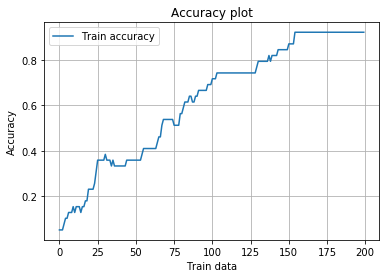

In [7]:
# plotting the accuracy plot
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.title('Accuracy plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [8]:
# Function embedding input sentence into glove embeddings
def sent_embeddings(ip_sent, glove, glove_words):
    
    sent_emb = np.zeros(300)
    cnt = 0
    
    for word in ip_sent.split():
        if word.lower() in glove_words:
            sent_emb += glove[word.lower()]
            cnt += 1
        
    if cnt != 0:
        sent_emb /= cnt
        
    return sent_emb.reshape(1, -1)

In [9]:
# function to start the chat
def chat():
    
#     loading glove model for word embeddings of input sentence
    with open(r'D:\b\my work\programming\appliedaicourse\applied ai ipython notebooks\assignments\glove_vectors', 'rb') as f:
        
        glove = pickle.load(f)
        glove_words = glove.keys()
        
    print('Start talking with the BOT (Type "quit" or "exit" to stop)!')
    
    while True:
        
        inp = input('You: ')
        
        if inp.lower() == 'quit' or inp.lower() == 'exit':
            break
        
        results = model.predict(sent_embeddings(inp, glove, glove_words)) # function to embed sentence using glove model.

        results_index = np.argmax(results)

        tag = ys_dict[results_index]
        
        if results[0, results_index] > 0.7: # threshold to give the exact output
            for tg in data['intents']:
                if tg['tag'] == tag:
                    responses = tg['responses']

            print(random.choice(responses))
            
        else: # if model is not confident even 70 percent
            neg_responses = ['I didn\'t get that, try again.', 'I request you to please ask me something else.', \
                             'Ask me something else.', 'I have not yet learned about that.', \
                             'I wish I could have helped, please ask something else.', 'really sorry, I don\'t have an answer to that yet']
            print(random.choice(neg_responses))
            
# calling the chat function
chat()

Start talking with the BOT (Type "quit" or "exit" to stop)!
You: hello
Hello!
You: what is your name
You can call me Jayant
You: you are amazing
I request you to please ask me something else.
You: exit
